In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

words = open('../../names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((5, 2), generator=g)
W1 = torch.randn((6, 20), generator=g)
b1 = torch.randn(20, generator=g)
W2 = torch.randn((20, 5), generator=g)
b2 = torch.randn(5, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [36]:
def draw_scatter():
    # visualize dimensions 0 and 1 of the embedding matrix C for all characters
    plt.figure(figsize=(8,8))
    plt.scatter(C[:,0].data, C[:,1].data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    plt.grid('minor')

In [37]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(["cab", "bad","cad","dad","aaa","aba","bab","caa"])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([32, 3]) torch.Size([32])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


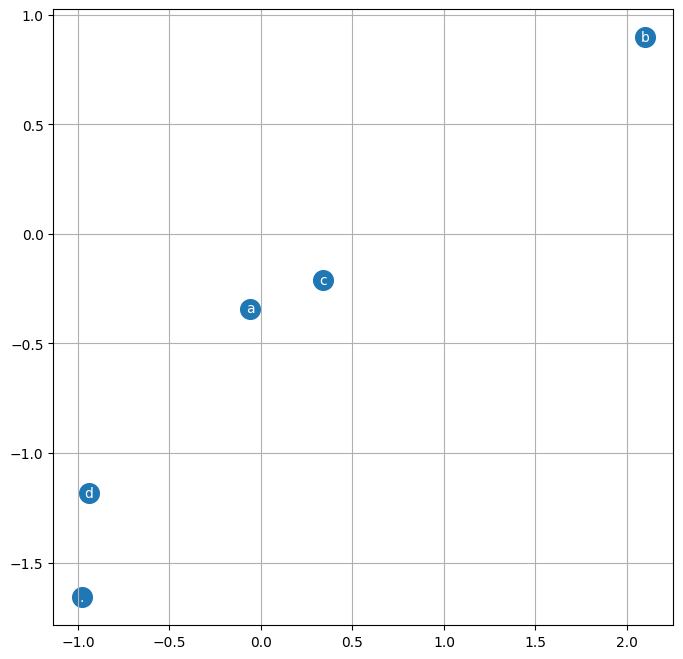

In [38]:
draw_scatter()

In [39]:

lri = []
lossi = []
stepi = []
for i in range(100):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.data.item())

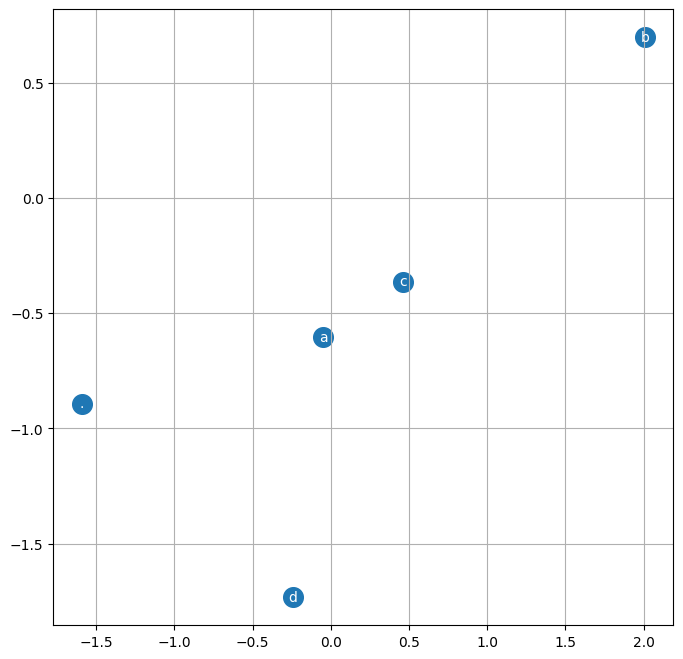

In [40]:
draw_scatter()